# Loading

In [14]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
# import pandas_datareader as web
import datetime as dt

# ML/DL imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed,GRU,Embedding
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
import json
seed(1)

In [15]:
filepath='model5/'

In [16]:
train_data = pd.read_csv('train.csv', index_col=0)
test_data = pd.read_csv('test.csv', index_col=0)
data_oil = pd.read_csv('oil.csv')
samp_subm = pd.read_csv('sample_submission.csv')
data_holi = pd.read_csv('holidays_events.csv')
data_store =  pd.read_csv('stores.csv')
data_trans = pd.read_csv('transactions.csv')


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
## holiday 重複的部分做處理
#  type：{'holiday':3,'transfer':4,'addition:'0','bridge':1,'work day':5,'event':2} nan=6
#  local:{'local':0,'region':1,'nation':2} nan=3
data_holi = data_holi[['date','type','locale']]
data_holi['locale'].replace({'Local':1,'Regional':2,'National':3},inplace=True)
data_holi['type'].replace({'Holiday':6,'Transfer':5,'Additional':4,'Bridge':3,'Event':2,'Work Day':1},inplace=True)
data_holi[['type','locale']]=data_holi[['type','locale']].astype(int)
data_holi = data_holi.groupby(['date'],as_index=False).agg({'type':'mean','locale':'first'})

In [18]:
all_data = pd.concat([train_data,test_data],ignore_index=True)
all_data['date'] =  pd.to_datetime(all_data['date'])
data_holi['date'] = pd.to_datetime(data_holi['date'])
data_oil['date'] = pd.to_datetime(data_oil['date'])

In [19]:
df_train1 = all_data.merge(data_holi, on = 'date', how='left')
df_train1 = df_train1.merge(data_oil, on = 'date', how='left')
df_train1 = df_train1.merge(data_store, on = 'store_nbr', how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})
df_train1['day_of_week'] = df_train1['date'].dt.day_name()


In [31]:

# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df['week'] = df['date'].dt.isocalendar().week
# df['quarter'] = df['date'].dt.quarter


train_columns = ['date','store_nbr','family','sales','day_of_week']
df = df_train1[train_columns]

In [32]:
num_test,num_train = len(test_data),len(train_data)

In [33]:
df_copy = df.copy()

# EDA
df = train + test

### 圖示化


In [ ]:

# buf = df[['date','store_nbr','sales','family']].groupby(['store_nbr','family','date'],as_index = False).agg({"sales":"mean"})
# store = []
# for i in range(1,55):
#     f = list(buf[buf['store_nbr']==i].drop(columns = ['store_nbr']).groupby(['family']))
#     store1 = f[0][1].drop(columns=['family'])
#     for i in range(1,33):
#         store1 = store1.merge(f[i][1].drop(columns=['family']), on = 'date', how='left')
#         store1 = store1.rename(columns = {"sales_x": "sales" ,"sales_y" : f[i][0]})
#     store1 = store1.rename(columns = {"sales": f[0][0]})  
#     store.append(store1)


### Transform

In [34]:
df =df_copy.copy()

In [ ]:
# df.info()

In [ ]:
# df.isnull().sum()

In [35]:
df['day_of_week'].replace({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7},inplace=True)
df['day_of_week'] = df['day_of_week'].astype(int)

In [36]:
object_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
number_cols = [cname for cname in df.columns if df[cname].dtype!="object" and cname!='date' and cname!='sales']
# buf[col] = ordinal_encoder.fit_transform(buf[col])
print(object_cols,number_cols)

['family'] ['store_nbr', 'day_of_week']


In [37]:
ordinal_encoder = OrdinalEncoder()
df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

### Seperate By family

In [47]:
# train_x_all = df[:num_train].copy()
train_x_all = df.copy()

train_x_all = list(train_x_all.groupby(["family"],as_index=True))

In [39]:
group = [31,30,27,26,23,19,18,16,15,10,6,1]
A_train_x_all = [ train_x_all[i] for i in group]

In [40]:
condition ={
    'family':'mean',
    'day_of_week':'mean'#!
    }
train_condition = condition.copy()
train_condition['sales'] ='max'

In [103]:
history_input = 30
train_f_map=list()
train_input = []
train_output = []
for i in range(len(train_x_all)):
    scaler = MinMaxScaler(feature_range=(0,1))
    family_num,train_x = train_x_all[i][0],train_x_all[i][1]


    for col in number_cols+object_cols:
        train_x[col] = scaler.fit_transform(train_x[col].values.reshape(-1,1))

    store = list(train_x.groupby(['store_nbr'],as_index=False))
    for s in range(len(store)):
        table = store[s][1]
        # table = table.groupby(['date'],as_index=False).agg({"sales":"max","store_nbr":"mean","family":"mean"})
        table = table.groupby(['date']).agg({"sales":"max","store_nbr":"mean","family":"mean","day_of_week":"mean"})
        
        table_x = table[:589]
        table_y = table_x[['sales']]
        
        table_x.drop(columns=['sales'],inplace=True)
        # table_y.drop(columns=['date'],inplace=True)

        for j in range(len(table_x)-history_input+1):
            train_input.append(table_x[j:j+history_input].values)
            train_output.append(table_y.iloc[j+history_input-1])
train_input=np.array(train_input)
train_output=np.array(train_output)


C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\ProgramData\Anaconda3\envs\ProjectPy37\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=err

In [ ]:
# def Make_Model_GRU():    

In [104]:
train_f_map.append([train_input,train_output])

In [121]:
def Multi_Step_LSTM_model():
    
    # Use Keras sequential model
    model = Sequential()    
    

    model.add(GRU(4, input_shape=train_input[0].shape))
    model.add(Dense(1))
    
    # The output layer with linear activation to predict Open stock price
    model.add(Dense(units=1, activation = "linear"))
    
    return model

In [124]:
for i in range(len(train_f_map)):
    print(f"Model {i} training")
    train_input = train_f_map[i][0]
    train_output = train_f_map[i][1]

    model = Multi_Step_LSTM_model()
    model.compile(optimizer='adam', loss='mean_squared_error')#, metrics = ['accuracy'])
    # early_stop = EarlyStopping(monitor='val_loss',patience=2,verbose=1)
    history = model.fit(train_input,train_output,batch_size=1, epochs=1)#,callbacks=early_stop)
    train_f_map[i].append(model)
    train_f_map[i].append(history)
    # break


Model 0 training
   653/997920 [..............................] - ETA: 2:17:24 - loss: 520251.6287

KeyboardInterrupt: 

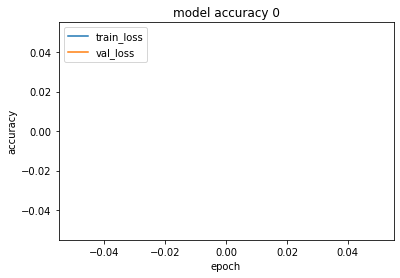

model_f0Saved model to disk


In [55]:
def draw(history,num):
    # val_acc = np.mean(history.history['val_accuracy'])
    # print("\n%s: %.2f%%" % ('val_acc', val_acc*100))
    # plt.plot(history.history['accuracy'])
    # plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy '+str(num))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    # plt.legend(['train_acc', 'validation_acc','train_loss','val_loss'], loc='upper left')
    plt.legend(['train_loss','val_loss'], loc='upper left')

    # plt.legend(['train','loss'], loc='upper left')
    plt.show()
for i in range(len(train_f_map)):
    model = train_f_map[i][2]
    history = train_f_map[i][3]

    draw(history,i)
    # serialize model to JSON
    model_json = model.to_json()
    with open(filepath+"model_f"+str(i)+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(filepath+"model_f"+str(i)+".json.h5")
    print("model_f"+str(i)+"Saved model to disk")
    # break

# Perdict

In [78]:
test_x =  df[num_train:].copy().drop(columns=['sales','date'])
cols = ['family','store_nbr']
for col in cols:
    test_x[col] =  scaler.fit_transform(test_x[col].values.reshape(-1,1))

In [79]:
weeklist=[]
test_x_week = test_x[cols]
test_x_week['day_of_week'] = scaler.fit_transform(test_x["day_of_week"].values.reshape(-1,1))
for item in test_x_week.groupby(['day_of_week']):
    weeklist.append(item[0])
weeklist

[0.0,
 0.16666666666666666,
 0.33333333333333337,
 0.5,
 0.6666666666666666,
 0.8333333333333334,
 0.9999999999999999]

In [101]:
test_input=[]
for i in range(len(test_x['family'])):
    store_num = test_x['store_nbr'].iloc[i]
    week = test_x['day_of_week'].iloc[i]
    family = test_x['family'].iloc[i]
    instance = []
    num = 7
    for k in range(0,30):
        if week==0:
            week+=7
        instance.append([store_num,family,weeklist[week-1]])
        week-=1
    test_input.append(instance)
    break
test_input = np.array(test_input)
print(test_input)

[[[0.         0.         0.33333333]
  [0.         0.         0.16666667]
  [0.         0.         0.        ]
  [0.         0.         1.        ]
  [0.         0.         0.83333333]
  [0.         0.         0.66666667]
  [0.         0.         0.5       ]
  [0.         0.         0.33333333]
  [0.         0.         0.16666667]
  [0.         0.         0.        ]
  [0.         0.         1.        ]
  [0.         0.         0.83333333]
  [0.         0.         0.66666667]
  [0.         0.         0.5       ]
  [0.         0.         0.33333333]
  [0.         0.         0.16666667]
  [0.         0.         0.        ]
  [0.         0.         1.        ]
  [0.         0.         0.83333333]
  [0.         0.         0.66666667]
  [0.         0.         0.5       ]
  [0.         0.         0.33333333]
  [0.         0.         0.16666667]
  [0.         0.         0.        ]
  [0.         0.         1.        ]
  [0.         0.         0.83333333]
  [0.         0.         0.66666667]
 

In [102]:
y_pred = model.predict(test_input)
print(y_pred)

[[nan]]


In [ ]:
test_data = pd.read_csv('test.csv')
submit = test_data[['id']]
submit['sales'] = test_output

In [ ]:
submit.to_csv(filepath+"submit.csv",index=False,sep=',')
import zipfile
with zipfile.ZipFile(filepath+'submit.zip', 'w') as zf:
    zf.write(filepath+'submit.csv')